In [1]:
# importing libraries
import cv2
from numpy import zeros, ones
from numpy.random import randn, randint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout, Flatten, InputLayer, Reshape, Conv2DTranspose, LeakyReLU
from keras.optimizers import Adam
from PIL import Image

import os
from os import listdir

import pickle

In [3]:
# mounting drive to get data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# path of the train set
images_path = "/content/drive/MyDrive/Project/Data/Dataset/"

In [11]:
# getting train and train cleaned images from folder
dirty_images_path = [images_path + 'train/' + f for f in os.listdir(images_path + 'train/')]
dirty_images_path.sort()
clean_images_path = [images_path + 'train_cleaned/' + f for f in os.listdir(images_path + 'train_cleaned/')]
clean_images_path.sort()
# getting the test files path
test_images_path = [images_path + 'test/' + f for f in os.listdir(images_path + 'test/')]
number_of_train_images = len(dirty_images_path)
number_of_test_images = len(test_images_path)
# for i in range(5):
#   print(dirty_images_path[i], " ", clean_images_path[i])

In [8]:
# define row and col
width, height = 320, 240
# width, height = 240, 120

In [7]:
# function for reading images
def read_images(image_paths):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (width, height))
        image = image.astype('float32') / 255.0
        images.append(image)
    return np.array(images, dtype=float)

In [ ]:
# reading train images as np_arrays
train_dirty_images = read_images(dirty_images_path)
train_clean_images = read_images(clean_images_path)

In [6]:
# function for showing the images
def plot_image(image1, image2):
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(image1, cmap = 'gray')
  plt.subplot(1,2,2)
  plt.imshow(image2, cmap = 'gray')
  plt.show()

In [12]:
# getting test data
test_images = read_images(test_images_path)

In [ ]:
# Define the generator model
def generator_model():
	model = Sequential()
	model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=(height, width, 1)))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Conv2D(8, (5, 5), activation='relu', padding='same'))
	# model.add(MaxPooling2D(pool_size=(3, 3)))
	# model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Flatten())
 
	n_nodes = width//16 * height//16 * 8
	model.add(Dense(n_nodes))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((height//16, width//16, 8)))
	# upsampleing
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsampleing
	model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# # upsampleing
	model.add(Conv2DTranspose(16, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# # upsampleing
	model.add(Conv2DTranspose(16, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (height, width), activation='relu', padding='same'))
	return model

In [ ]:
# Define the discriminator model
def discriminator_model(in_shape=(height, width, 1)):
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
def model_gan(generator, discriminator):
	discriminator.trainable = False
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	# getting random images from the dataset
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1)) # real
	return X, y

In [ ]:
def generate_fake_points(batch_size):
	X = randn(batch_size * width * height)
	# reshape into a batch of inputs
	X = X.reshape(batch_size, height, width)
	return X

In [ ]:
def generate_fake_samples(generator, batch_size):
	# generate points in latent space
	x_input = generate_fake_points(batch_size)
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((batch_size, 1))  # fake
	return X, y

In [ ]:
def train_gan(generator_model, discriminator_model, gan_model, clean_images, epochs):
	batch_size = 8
	bat_per_epo = int(clean_images.shape[0] / batch_size)
	half_batch = int(batch_size / 2)
	for i in range(epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(clean_images, half_batch)
			loss_real, _ = discriminator_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(generator_model, half_batch)
			loss_fake, _ = discriminator_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_fake_points(batch_size)
			y_gan = ones((batch_size, 1))
			gan_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('Epoch:%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, loss_real, loss_fake, gan_loss))

In [ ]:
discriminator = discriminator_model()
generator = generator_model()
gan_model = model_gan(generator, discriminator)
epochs = 50
train_gan(generator, discriminator, gan_model, train_clean_images, epochs)

1/1 [==============================] - 0s 173ms/step


Epoch>1, Batch 1/18, d1=0.681, d2=0.697 g=0.704
1/1 [==============================] - 0s 25ms/step
Epoch>1, Batch 2/18, d1=0.001, d2=0.961 g=0.534
1/1 [==============================] - 0s 18ms/step
Epoch>1, Batch 3/18, d1=0.001, d2=1.684 g=0.482
1/1 [==============================] - 0s 21ms/step
Epoch>1, Batch 4/18, d1=0.070, d2=1.251 g=1.522
1/1 [==============================] - 0s 23ms/step
Epoch>1, Batch 5/18, d1=2.033, d2=0.805 g=0.565
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 6/18, d1=0.219, d2=1.060 g=0.529
1/1 [==============================] - 0s 18ms/step
Epoch>1, Batch 7/18, d1=0.156, d2=1.037 g=0.653
1/1 [==============================] - 0s 19ms/step
Epoch>1, Batch 8/18, d1=0.292, d2=0.896 g=0.799
1/1 [==============================] - 0s 32ms/step
Epoch>1, Batch 9/18, d1=0.437, d2=0.829 g=0.830
1/1 [==============================] - 0s 19ms/step
Epoch>1, Batch 10/18, d1=0.423, d2=0.812 g=0.860
1/1 [==============================] - 0s 23ms/step

In [ ]:
pickle.dump(generator, open('/content/drive/MyDrive/Project/Data/Models/generator.pkl', 'wb'))
pickle.dump(discriminator, open('/content/drive/MyDrive/Project/Data/Models/discriminator.pkl', 'wb'))
pickle.dump(gan_model, open('/content/drive/MyDrive/Project/Data/Models/gan_model.pkl', 'wb'))

In [13]:
loaded_model = pickle.load(open('/content/drive/MyDrive/Project/Data/Models/generator.pkl', 'rb'))

In [ ]:
dirty_image = test_images[0].reshape(1, height, width)
X = generator.predict(dirty_image)
X.shape

1/1 [==============================] - 0s 21ms/step


(1, 240, 320, 1)

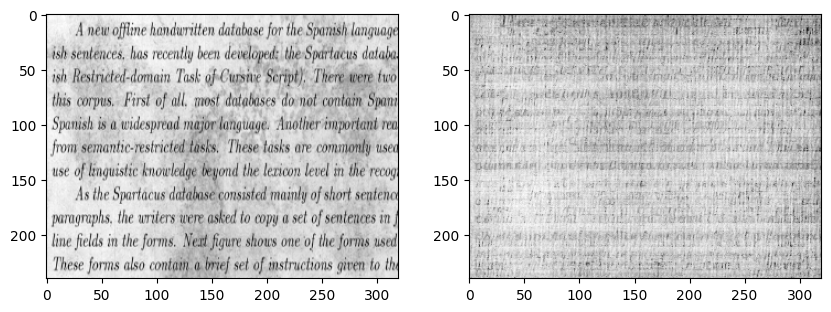

In [ ]:
plot_image(test_images[0], X[0])